# **Tugas Besar A - IF3270 Pembelajaran Mesin**
Authors:
1. 13519096 Girvin Junod
2. 13519116 Jeane Mikha Erwansyah
3. 13519131 Hera Shafira
4. 13519188 Jeremia Axel
---

## Install Libraries

In [ ]:
!pip install icecream
!pip install networkx
!pip install pandas
!pip install numpy
!pip install matplotlib

## Load libraries

In [368]:
import pandas as pd
import os, subprocess, sys
import json, math, typing, copy
import numpy as np, networkx as nx, matplotlib as plt
from icecream import ic

## Enums

In [369]:
class LayerType:
	INPUT = "input"
	HIDDEN = "hidden"
	OUTPUT = "output"

class ActivationFunction:
	SIGMOID = "sigmoid"
	RELU = "relu"
	SOFTMAX = "softmax"
	LINEAR = "linear"

## Utility Functions

In [370]:
class Utils:
	@staticmethod
	def matrix_dimension(mat: typing.List[list]) -> typing.Tuple[int, int]:
		return len(mat), len(mat[0])

	@staticmethod
	def get_layer_type(type: str):
		if type == 'input':
			return LayerType.INPUT
		elif type == 'hidden':
			return LayerType.HIDDEN
		elif type == 'output':
			return LayerType.OUTPUT
	  
	@staticmethod
	def get_activation_func(activation_func: str):
		if activation_func == 'sigmoid':
		  return ActivationFunction.SIGMOID
		elif activation_func == 'linear':
		  return ActivationFunction.LINEAR
		elif activation_func == 'relu':
		  return ActivationFunction.RELU
		elif activation_func == 'softmax':
		  return ActivationFunction.SOFTMAX
		  
	@staticmethod
	def parse_json(filename):
		with open(filename, 'r') as f:
			data = json.load(f)
			return data

	@staticmethod
	def export_json(filename, data):
		with open(filename, 'w') as f:
			f.write(json.dumps(data, indent=2))

	@staticmethod
	def install(package):
		subprocess.check_call([sys.executable, "-m", "pip", "install", ''.join(package)])

## Layer Class

In [371]:
class Layer:
	def __init__(self, weights: typing.List[list],
				 bias_weights: typing.List[float],
				 values: typing.List[list],
				 layer_type: LayerType,
				 label: str,
				 num_nodes: int,
				 activation_func: ActivationFunction):
		self.weights = np.array(weights, dtype=float)
		self.bias_weights = np.array(bias_weights, dtype=float)
		self.values = np.array(values, dtype=float)
		self.label = label
		self.type = layer_type
		self.num_nodes = num_nodes
		self.activation_func = activation_func

	def __str__(self):
		if self.type != LayerType.INPUT:
			res = "{} layer with {} weights".format(self.label, len(self.weights))
		else:
			res = "{} layer with {} values".format(self.label, len(self.values))
		return res

## Graph Class

In [372]:
class Graph:
	def __init__(self, layers: typing.List[Layer]=None):
		self.layers = []
		if layers is not None:
			self.layers = layers

	def __str__(self):
		return "Graph with {} layers".format(len(self.layers))

	def add_layer(self, layer: Layer):
		self.layers.append(layer)

	def net_value_vector(self, layer_idx: int):
		return np.array(
			[(
				np.dot(
					np.transpose(self.layers[layer_idx].weights),
					self.layers[layer_idx-1].values[0]
				) + self.layers[layer_idx].bias_weights
			).tolist()], 
			dtype=float
		)

	def net_value_batch(self, layer_idx):
		return np.dot(
			self.layers[layer_idx - 1].values,
			self.layers[layer_idx].weights) + self.layers[layer_idx].bias_weights

	def layer_value(self, layer_idx: int):
		layer = self.layers[layer_idx]

		if len(self.layers[layer_idx - 1].values) == 1:
			layer.values = self.net_value_vector(layer_idx)
		else:
			layer.values = self.net_value_batch(layer_idx)

		if layer.activation_func == ActivationFunction.LINEAR:
			layer.values = self.linear_activation(layer.values)
		elif layer.activation_func == ActivationFunction.SIGMOID:
			layer.values = self.sigmoid_activation(layer.values)
		elif layer.activation_func == ActivationFunction.RELU:
			layer.values = self.relu_activation(layer.values)
		elif layer.activation_func == ActivationFunction.SOFTMAX:
			layer.values = self.softmax_activation(layer.values)

	def linear_activation(self, net_mat):
		return net_mat

	def sigmoid_activation(self, net_mat):
		dim = Utils.matrix_dimension(net_mat)
		for i in range(dim[0]):
			for j in range(dim[1]):
				net_mat[i][j] = 1 / (1 + math.exp(-1 * net_mat[i][j]))
		return net_mat

	def relu_activation(self, net_mat):
		dim = Utils.matrix_dimension(net_mat)
		for i in range(dim[0]):
			for j in range(dim[1]):
				net_mat[i][j] = max(0, net_mat[i][j])
		return net_mat

	def softmax_activation(self, net_mat):
		dim = Utils.matrix_dimension(net_mat)
		sum_exp = []
		for i in range(dim[0]):
			sum = 0
			for j in range(dim[1]):
				sum += math.exp(net_mat[i][j])
			sum_exp.append(sum)

		for i in range(dim[0]):
			for j in range(dim[1]):
				net_mat[i][j] = math.exp(net_mat[i][j]) / sum_exp[i]

		return net_mat

	def predict(self, input):
		np_input = np.array(input)
		if len(np_input.shape)==1:
			self.layers[0].values = [input]
		else:
			self.layers[0].values = input
		
		self.layers[0].num_nodes = len(input)
		for i in range(1, len(self.layers)):
			self.layer_value(i)
		res = self.layers[len(self.layers) - 1].values
			
		if len(res) == 1:
			return res[0]
		else:
			return res
			
	def load_graph(self, filename):
		'''
		load a json file to Graph
		'''
		data = Utils.parse_json(filename) # parse from json
		for layer in data["layers"]:
			type = Utils.get_layer_type(layer["type"])
			if type != LayerType.INPUT:
				act = Utils.get_activation_func(layer["activation_func"])
	  
			if type:
				new_layer = Layer(
					weights=layer["weights"] if type != LayerType.INPUT else None,
					bias_weights=layer["bias_weights"] if type != LayerType.INPUT else None,
					values=[] if type == LayerType.INPUT else [0]*layer["num_nodes"],
					layer_type=type,
					label=layer["label"],
					num_nodes=layer["num_nodes"] if type!=LayerType.INPUT else None,
					activation_func=act if type != LayerType.INPUT else None)
				self.add_layer(new_layer)

	def visualize(self, filename="data/plot.png"):
		visual = nx.DiGraph()

		for i in range(len(self.layers)):
			layer = self.layers[i]
			visual.add_node(layer.label, pos=(0, i))

		nodes = list(visual.nodes)
		for i in range(len(nodes)):
			try:
				visual.add_edge(nodes[i], nodes[i+1])
			except:
				pass

		pos = nx.get_node_attributes(visual, "pos")

		nx.draw(
			visual,
			pos=pos,
			edge_color="black",
			width=1,
			linewidths=1,
			node_size=500,
			node_color="pink",
			with_labels = True)

		edges = list(visual.edges)
		labels = dict()
		for i in range(len(edges)):
			labels[edges[i]]= "w_[{}{}]".format(list(edges[i])[0], list(edges[i])[1])

		nx.draw_networkx_edge_labels(
			visual,
			pos,
			edge_labels=labels,
			font_color="red",
			rotate=False)
		# plt.pyplot.show()
	
		if os.path.exists(filename): os.remove(filename)
		plt.pyplot.savefig(filename)

	def display_table(self):
		count = 0
		for index, layer in enumerate(self.layers):
			print("------------------------------")
			print("Layer: {}".format(index))

			print("Layer Type: {}".format(layer.type))
			print("Values:")
			print(layer.values)
			if layer.type != LayerType.INPUT:
				print("Weight: ")
				print(layer.weights)
				
				print("Bias: ")
				print(layer.bias_weights)
	
				print("Activation Function: {}".format(layer.activation_func))
			
			if (layer.type == LayerType.HIDDEN):
				count+=1
		
		print("------------------------------")
		print("Output: ")
		if (len(self.layers[0].values) != 0):
			print(self.predict(self.layers[0].values))
		else:
			print("No input")
		print("Number of hidden layers: {}".format(count))

## Main Function

### XOR Sigmoid Model

In [373]:
np.set_printoptions(suppress=True)
graphSigmoid = Graph()
graphSigmoid.load_graph('data/xor_sigmoid.json')

### Visualisasi Model

In [374]:
graphSigmoid.display_table()

------------------------------
Layer: 0
Layer Type: input
Values:
[]
------------------------------
Layer: 1
Layer Type: hidden
Values:
[0. 0.]
Weight: 
[[ 20. -20.]
 [ 20. -20.]]
Bias: 
[-10.  30.]
Activation Function: sigmoid
------------------------------
Layer: 2
Layer Type: output
Values:
[0.]
Weight: 
[[20.]
 [20.]]
Bias: 
[-30.]
Activation Function: sigmoid
------------------------------
Output: 
No input
Number of hidden layers: 1


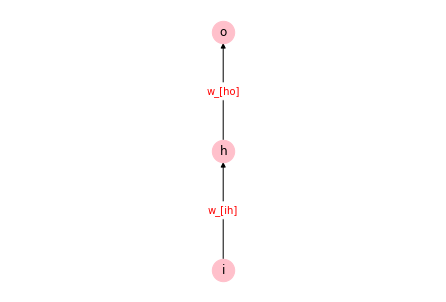

In [375]:
graphSigmoid.visualize()

#### Input 1 Instance

In [376]:
graphSigmoid.predict([0,0])
graphSigmoid.display_table()

------------------------------
Layer: 0
Layer Type: input
Values:
[[0, 0]]
------------------------------
Layer: 1
Layer Type: hidden
Values:
[[0.0000454 1.       ]]
Weight: 
[[ 20. -20.]
 [ 20. -20.]]
Bias: 
[-10.  30.]
Activation Function: sigmoid
------------------------------
Layer: 2
Layer Type: output
Values:
[[0.00004544]]
Weight: 
[[20.]
 [20.]]
Bias: 
[-30.]
Activation Function: sigmoid
------------------------------
Output: 
[0.00004544]
Number of hidden layers: 1


#### Input batch

In [377]:
graphSigmoid.predict([[0,0],[0,1],[1,0],[1,1]])
graphSigmoid.display_table()

------------------------------
Layer: 0
Layer Type: input
Values:
[[0, 0], [0, 1], [1, 0], [1, 1]]
------------------------------
Layer: 1
Layer Type: hidden
Values:
[[0.0000454 1.       ]
 [0.9999546 0.9999546]
 [0.9999546 0.9999546]
 [1.        0.0000454]]
Weight: 
[[ 20. -20.]
 [ 20. -20.]]
Bias: 
[-10.  30.]
Activation Function: sigmoid
------------------------------
Layer: 2
Layer Type: output
Values:
[[0.00004544]
 [0.99995452]
 [0.99995452]
 [0.00004544]]
Weight: 
[[20.]
 [20.]]
Bias: 
[-30.]
Activation Function: sigmoid
------------------------------
Output: 
[[0.00004544]
 [0.99995452]
 [0.99995452]
 [0.00004544]]
Number of hidden layers: 1


### XOR Relu-Linear Model

In [378]:
graphRelu = Graph()
graphRelu.load_graph('data/xor_relu_linear.json')

#### Visualisasi Model

In [379]:
graphRelu.display_table()

------------------------------
Layer: 0
Layer Type: input
Values:
[]
------------------------------
Layer: 1
Layer Type: hidden
Values:
[0. 0.]
Weight: 
[[1. 1.]
 [1. 1.]]
Bias: 
[ 0. -1.]
Activation Function: relu
------------------------------
Layer: 2
Layer Type: output
Values:
[0.]
Weight: 
[[ 1.]
 [-2.]]
Bias: 
[0.]
Activation Function: linear
------------------------------
Output: 
No input
Number of hidden layers: 1


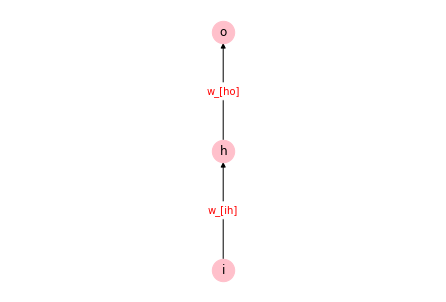

In [380]:
graphRelu.visualize()

#### Input 1 Instance

In [381]:
graphRelu.predict([0,0])
graphRelu.display_table()

------------------------------
Layer: 0
Layer Type: input
Values:
[[0, 0]]
------------------------------
Layer: 1
Layer Type: hidden
Values:
[[0. 0.]]
Weight: 
[[1. 1.]
 [1. 1.]]
Bias: 
[ 0. -1.]
Activation Function: relu
------------------------------
Layer: 2
Layer Type: output
Values:
[[0.]]
Weight: 
[[ 1.]
 [-2.]]
Bias: 
[0.]
Activation Function: linear
------------------------------
Output: 
[0.]
Number of hidden layers: 1


#### Input Batch

In [382]:
graphRelu.predict([[0,0],[0,1],[1,0],[1,1]])
graphRelu.display_table()

------------------------------
Layer: 0
Layer Type: input
Values:
[[0, 0], [0, 1], [1, 0], [1, 1]]
------------------------------
Layer: 1
Layer Type: hidden
Values:
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [2. 1.]]
Weight: 
[[1. 1.]
 [1. 1.]]
Bias: 
[ 0. -1.]
Activation Function: relu
------------------------------
Layer: 2
Layer Type: output
Values:
[[0.]
 [1.]
 [1.]
 [0.]]
Weight: 
[[ 1.]
 [-2.]]
Bias: 
[0.]
Activation Function: linear
------------------------------
Output: 
[[0.]
 [1.]
 [1.]
 [0.]]
Number of hidden layers: 1
